# K-Mean Brain Segmentation
This jupyter notebook will guide you on how to segment a 3D MRI image in different classes (eg: WM:White matter; GM:Grey matter; CSF:Cerebro-spinal fluid) using a K-means Model.

K-means Pseudocode:
  Specify number of clusters
  Randomly initialize k centroids
  Do
    Assign each point to closest ectroid
    Update centroid by computing mean in each cluster
  While
    Centroid positon is changing

In [62]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib as mpl    
import matplotlib.ticker as ticker
import numpy as np
import math
from scipy.stats import norm

# Set random seed so output is all same
np.random.seed(1)

# for display
sub_size = 16
sup_size=20

Load the input Image

In [63]:
dataFile = '../Data/brain.nii.gz'
brainImage = nib.load(dataFile).get_fdata()

Visualize the data in axial, coronal and sagittal view.

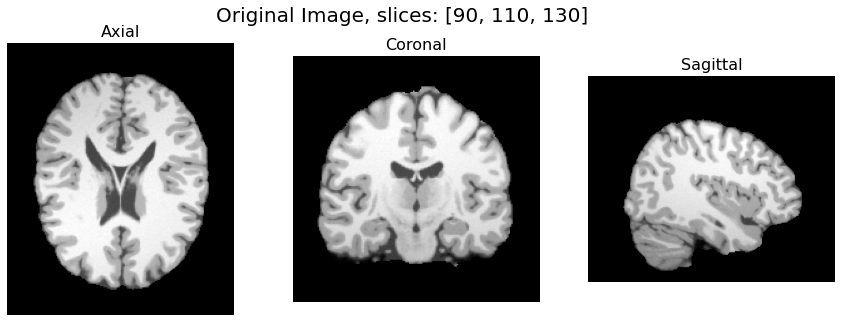

In [64]:
def plotOriginalImage(image, slices, title):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5),)
    fig.suptitle(title+', slices: ' + str(slices), fontsize=sup_size)
    ax1.imshow(image[slices[0], :, :], cmap='gray'); ax1.axis('off'); ax1.set_title('Axial', fontsize=sub_size)
    ax2.imshow(image[::-1,slices[1],::-1], cmap='gray'); ax2.axis('off'); ax2.set_title('Coronal', fontsize=sub_size)
    ax3.imshow(image[::-1,:,slices[2]], cmap='gray'); ax3.axis('off'); ax3.set_title('Sagittal', fontsize=sub_size)
    plt.show()

slices = [90, 110, 130]; bins = 100
plotOriginalImage(brainImage, slices, title='Original Image')

Let's plot the image histogram to see if we can see some intensities peaks that will be fitted by our K-means Model.

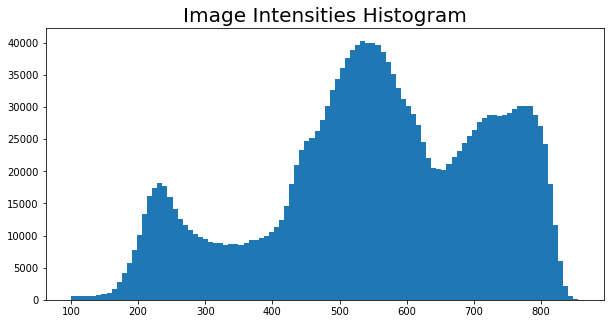

In [65]:
minIntensity = 100
brainIntensities = brainImage[brainImage > minIntensity]

plt.figure(figsize=(10, 5))
_ = plt.hist(brainIntensities.ravel(), bins) 
plt.title("Image Intensities Histogram", fontsize=sup_size)
plt.show()

If we look at the histogram of the image above, we can see that it has three peaks, most probably representing CSF, GM, and WM.

Now let's create our K-means model. 
The fact that the histogram has three peaks is telling us that we can set the number of clusters of the K-means to 4 (CSF, GM, WM, and background). 
Feel free to change the number of clusters to see how the results change.

In [77]:
# Here you can define the number of clusters of the K-means
K = 4 # feel free to change this value

In [ ]:
Let's build our K-mean Model. 

In [78]:
class KMeans(object):

    def __init__(self):  # No need to implement
        pass

    def pairwise_dist(self, image, centers, K):
        """
        Args:
            image: C x H x W  numpy array
            centers: K numpy array
            K: number of clusters
        Return:
                dist: N x M array, where dist[i] is the euclidean distance between X[i] and Y[j]
                """
        C, H, W = image.shape
        dists = np.zeros((K, C, H, W))
        for i in range(K):
            dists[i] = abs(image-centers[i])
        return dists

    def _update_assignment(self, image, centers, K):
        """
        Args:
            image: C x H x W  numpy array, the observations
            centers: K numpy array, where K is the number of clusters
            K: number of clusters
        Return:
            cluster_idx: C x H x W  numpy array, the cluster assignment for each point
        """
        cluster_idx = np.empty_like(image)
        distances = self.pairwise_dist(image, centers, K)
        cluster_idx = np.argmin(distances, axis=0)
        return cluster_idx

    def _update_centers(self, image, cluster_idx, K):
        """
        Args:
            image: C x H x W  numpy array, the observations
            cluster_idx: C x H x W  numpy array, the cluster assignment for each point
            K: number of clusters
        Return:
            centers: new centers, K numpy array, where K is the number of clusters
        """
        new_centers = np.empty([K])
        for i in range(K):
            indices = np.where(cluster_idx == i)
            if indices[0].size ==0:
              print('Center', i, 'is empty!')
              new_centers[i] = 0
            else:
                new_centers[i] = np.mean(image[indices])
        return new_centers

    def _get_loss(self, image, centers, cluster_idx, K):
        """
        Args:
            image: C x H x W  numpy array, the observations
            centers: K numpy array, where K is the number of clusters
            cluster_idx: C x H x W  numpy array, the cluster assignment for each point
            K: number of clusters
        Return:
            loss: a single float number, which is the objective function of KMeans. 
        """
        dists = self.pairwise_dist(image, centers, K)
        loss = 0.0
        for i in range(K):
            indices = np.where(cluster_idx == i)
            if indices[0].size ==0:
                print('Loss', i, 'is zero!')
                loss = loss + 0
            else:
                loss = loss + np.sum(dists[i][indices])
        return loss

Initialize the centers of K-Means

In [105]:
# We set a flag to choose initialize method
random_init = True

if random_init:
  # We initilize the centers by random
  centers = np.empty([K])
  for idx in range(K):
      randIndex = [np.random.randint(val) for val in brainImage.shape]
      centers[idx] = brainImage[randIndex[0],randIndex[1], randIndex[2]]
else:
  # We initilize the centers according to the brainImage Histogram
  plt.figure(figsize=(10, 5))
  val, binsH, _ = plt.hist(brainImage.ravel(), bins=K) 
  plt.title("Image Intensities Histogram", fontsize=sup_size)
  plt.show()
  centers = np.array([np.mean(binsH[:2]), np.mean(binsH[1:3]), np.mean(binsH[2:4]), np.mean(binsH[3:])])

We can now start with the K-means algorithm and see how well we can fit the data with our K-means model as well as plot our segmentation maps of our segmented brain structures.

Let's compute the initial segmentation (computing the posterior distribution and take the maximum argument) with this parameter initialization and show them. 

In [108]:
def plotSegmentation(segImage, slices, it=0):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,5))
    fig.suptitle('Segmentation at Iteration ' + str(it), fontsize=sup_size)

    cmp = mpl.colors.ListedColormap(['k', 'b', 'gray', 'w'])
    ax1.imshow(segImage[slices[0], :, :], cmap=cmp); ax1.axis('off'); ax1.set_title('Axial', fontsize=sub_size)
    ax2.imshow(segImage[::-1,slices[1],::-1], cmap=cmp); ax2.axis('off'); ax2.set_title('Coronal', fontsize=sub_size)
    img3 = ax3.imshow(segImage[::-1,:,slices[2]], cmap=cmp); ax3.axis('off'); ax3.set_title('Sagittal', fontsize=sub_size)
     
    fig.subplots_adjust(right=0.9) # set width of the left three subplot equal to 0.9 
    # set the size of colorbar
    l=0.92; b=0.12; w=0.015; h=1-2*b #left, bottom, width, hight
    # set the position of colorbar
    rect = [l,b,w,h]
    cbar_ax = fig.add_axes(rect)
    cb1 = fig.colorbar(img3, cax=cbar_ax)
    # set the scale of colobar
    tick_locator = ticker.MaxNLocator(nbins=4)
    cb1.locator = tick_locator
    # cb1.set_ticks([0,1])
    cb1.update_ticks()

    plt.show()

Center 3 is empty!


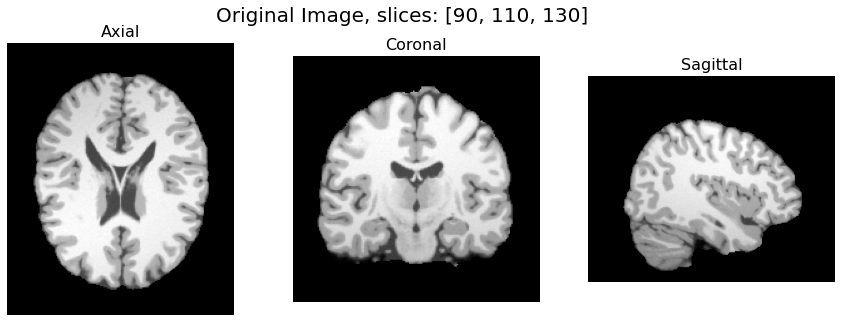

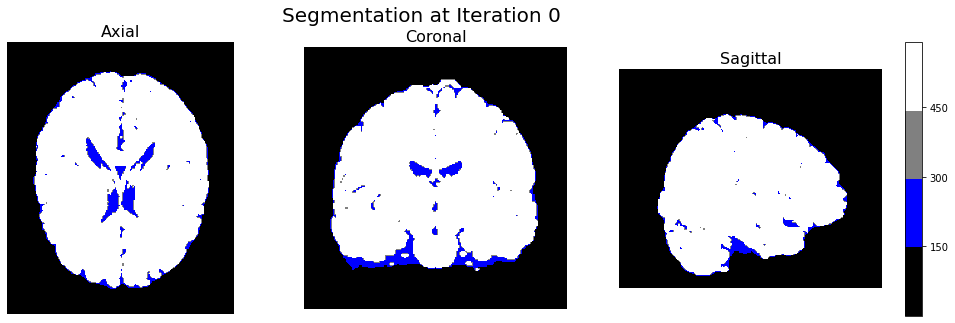

In [109]:
KMeans_model = KMeans()
cluster_idx = KMeans_model._update_assignment(brainImage, centers, K)
centers = KMeans_model._update_centers(brainImage, cluster_idx, K)

segImage = np.copy(brainImage)

# assign each pixel to cluster mean
for i in range(K):
    indices_current_cluster = np.where(cluster_idx == i)
    segImage[indices_current_cluster] = centers[i]

plotOriginalImage(brainImage, slices, title='Original Image')
plotSegmentation(segImage, slices, it=0)

Though sometimes the random initialization gives us poor initial segmentaion results, it's better than the hitogram initialize for deeply understanding the optimization process of K-Mean algorithem.

Let's run the K-Means algorithm for some iterations and see how the segmentation change. 

In [110]:
def plotLoss(lossHistory):
    if len(lossHistory) > 1:
        plt.figure(figsize=(10, 5))
        plt.title("Loss Function", fontsize=sup_size)
        plt.plot(lossHistory)
        plt.xlabel('iteration', fontsize=sub_size)
        plt.ylabel('loss', fontsize=sub_size)
        plt.show()    

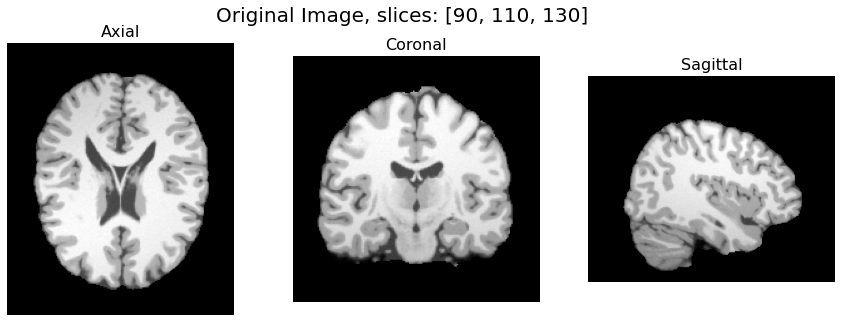

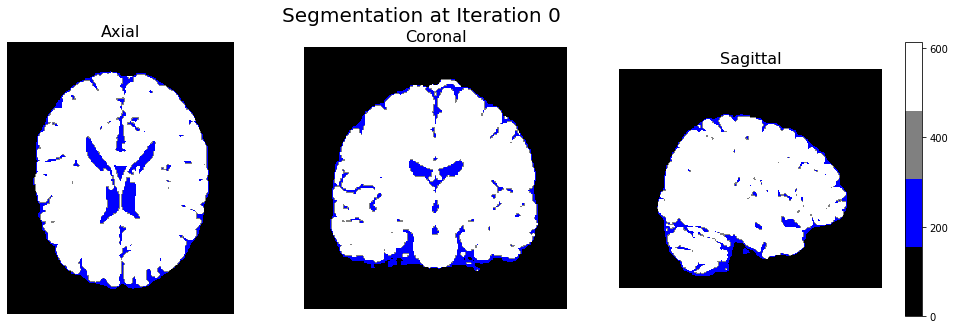

Iteration 0, Loss: 175575139.7949, Centers: [279.91761856  37.10066507 613.49012684   0.        ]
Iteration 1, Loss: 171604412.1521, Centers: [3.15318703e+02 8.66202573e+01 6.25798265e+02 1.22322838e-02]
Iteration 2, Loss: 166329780.5657, Centers: [3.45993519e+02 1.65058857e+02 6.35399566e+02 2.83352856e-02]
Iteration 3, Loss: 146554103.6676, Centers: [3.99874434e+02 2.17142658e+02 6.44801965e+02 6.06940465e-02]
Iteration 4, Loss: 125516558.2577, Centers: [4.48393271e+02 2.39916292e+02 6.63013478e+02 9.74810259e-02]


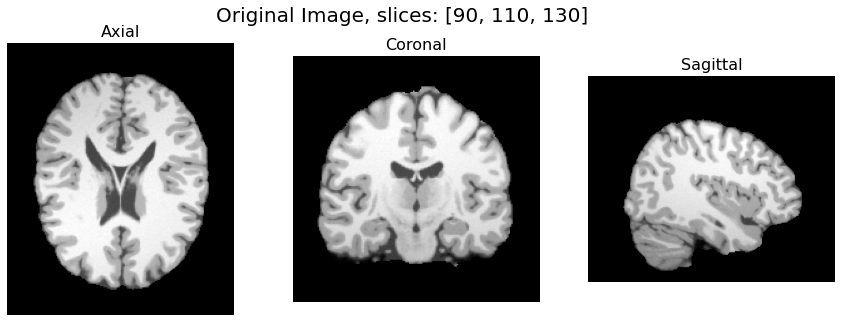

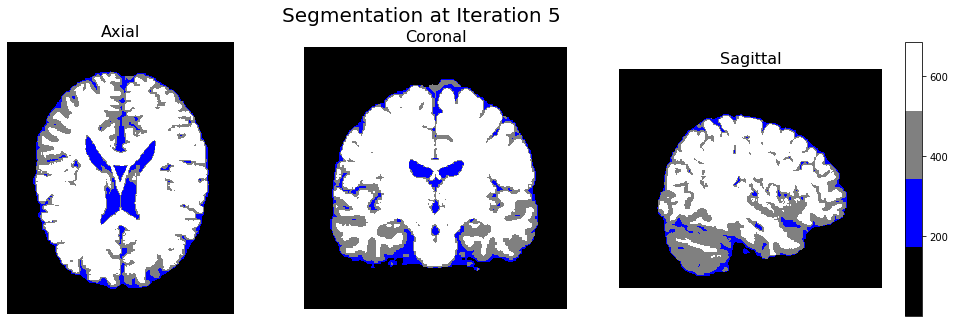

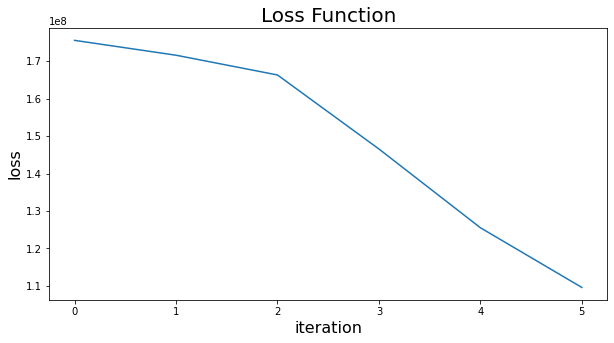

Iteration 5, Loss: 109565223.2516, Centers: [4.80275409e+02 2.53971890e+02 6.85344294e+02 1.16610933e-01]
Iteration 6, Loss: 100231709.4489, Centers: [5.00171915e+02 2.63679766e+02 7.03933499e+02 1.29416972e-01]
Iteration 7, Loss: 96247055.7515, Centers: [5.11974091e+02 2.70533032e+02 7.15844088e+02 1.38520306e-01]
Iteration 8, Loss: 94799670.3499, Centers: [5.18829554e+02 2.75099711e+02 7.22763125e+02 1.45787608e-01]
Iteration 9, Loss: 94314033.3008, Centers: [5.22719804e+02 2.78049848e+02 7.26567498e+02 1.51145665e-01]


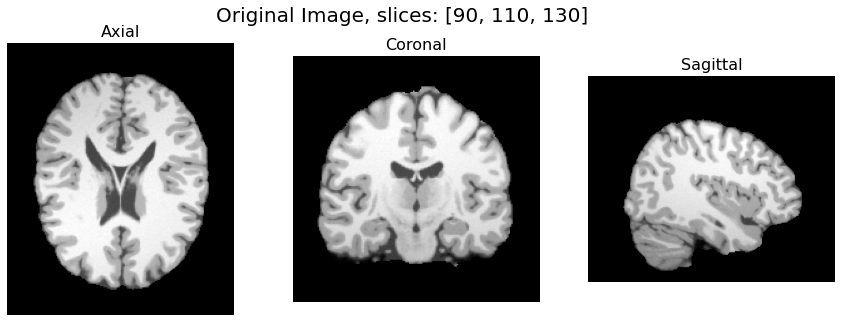

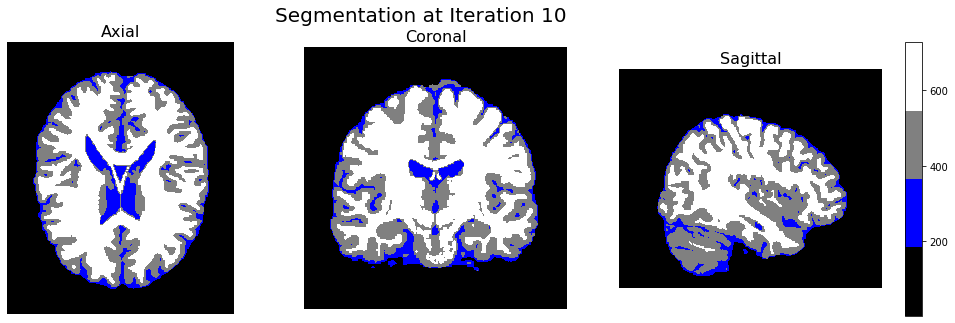

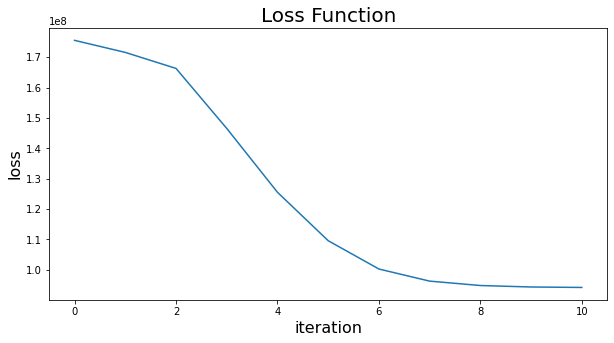

Iteration 10, Loss: 94164830.9437, Centers: [5.24848110e+02 2.79871005e+02 7.28555072e+02 1.54884301e-01]
Iteration 11, Loss: 94121754.5895, Centers: [5.25969101e+02 2.80929550e+02 7.29551776e+02 1.56969755e-01]
Iteration 12, Loss: 94108873.2929, Centers: [5.26584957e+02 2.81541216e+02 7.30084667e+02 1.58205632e-01]
Iteration 13, Loss: 94107127.4004, Centers: [5.26906506e+02 2.81888750e+02 7.30350588e+02 1.59095157e-01]
Iteration 14, Loss: 94106841.3694, Centers: [5.27076631e+02 2.82062114e+02 7.30497130e+02 1.59635221e-01]


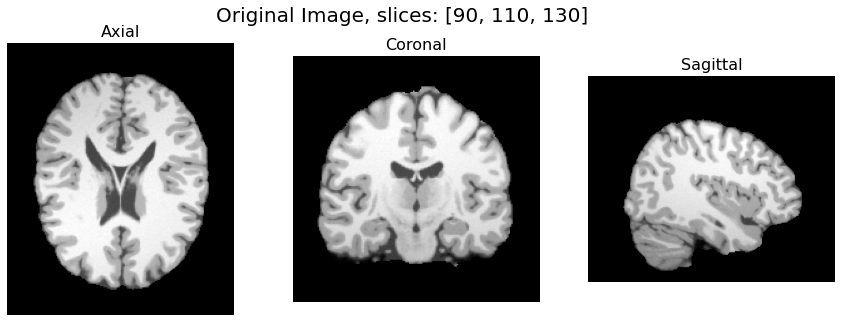

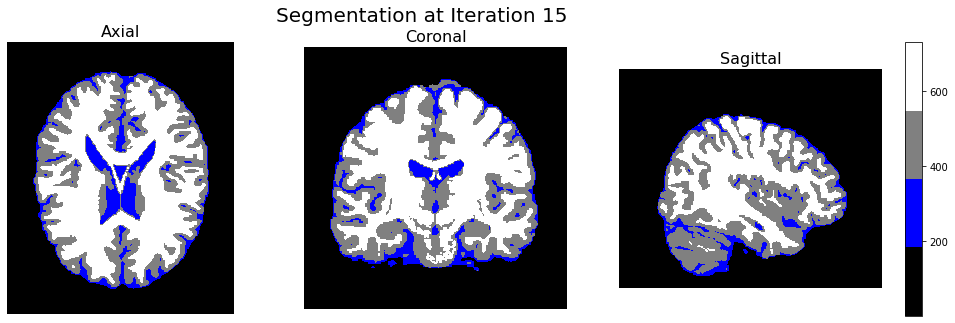

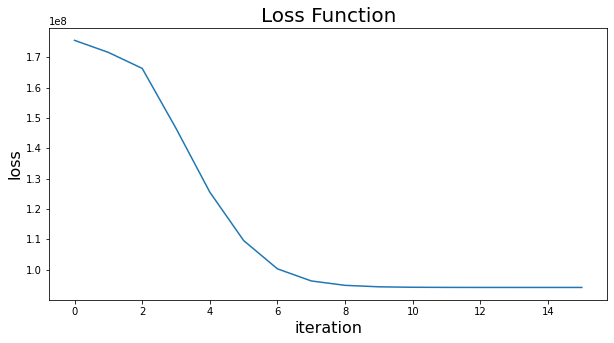

Iteration 15, Loss: 94105748.6128, Centers: [5.27171199e+02 2.82154145e+02 7.30579271e+02 1.59743339e-01]
Iteration 16, Loss: 94105292.6221, Centers: [5.27226928e+02 2.82212640e+02 7.30625468e+02 1.59797414e-01]
Iteration 17, Loss: 94105203.7748, Centers: [5.27254690e+02 2.82247885e+02 7.30645200e+02 1.59797414e-01]
Iteration 18, Loss: 94105126.6653, Centers: [5.27268795e+02 2.82258276e+02 7.30659425e+02 1.59851508e-01]
Iteration 19, Loss: 94104729.9475, Centers: [5.27277057e+02 2.82259745e+02 7.30669827e+02 1.59851508e-01]


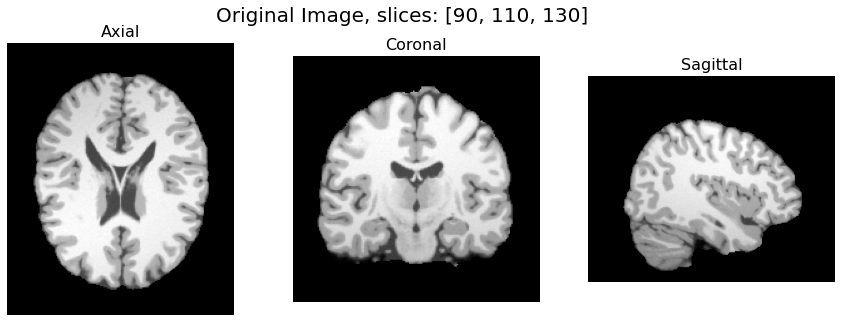

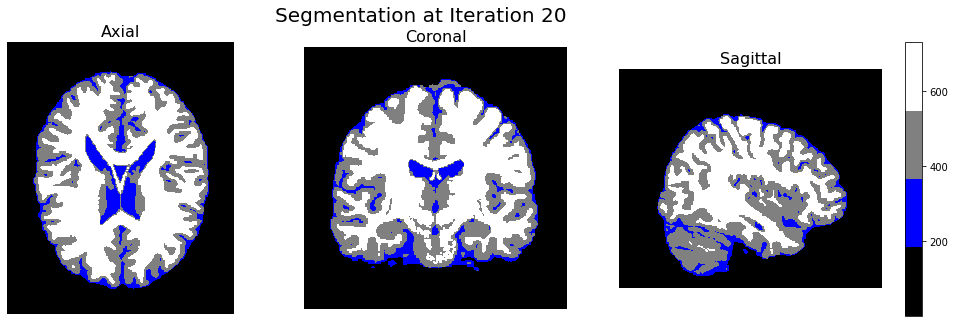

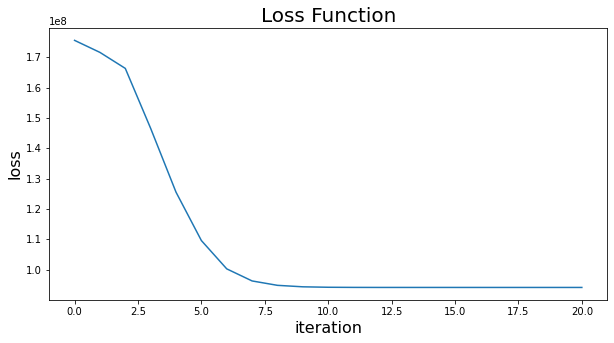

Iteration 20, Loss: 94104771.8494, Centers: [5.27280469e+02 2.82265252e+02 7.30671662e+02 1.59851508e-01]
Iteration 21, Loss: 94105606.5949, Centers: [5.27284040e+02 2.82273607e+02 7.30673345e+02 1.59986761e-01]
Iteration 22, Loss: 94105606.3188, Centers: [5.27287382e+02 2.82278013e+02 7.30675640e+02 1.59986761e-01]
Iteration 23, Loss: 94105566.9661, Centers: [5.27291155e+02 2.82282051e+02 7.30678699e+02 1.59986761e-01]
Iteration 24, Loss: 94105593.5317, Centers: [5.27292065e+02 2.82283887e+02 7.30679005e+02 1.59986761e-01]


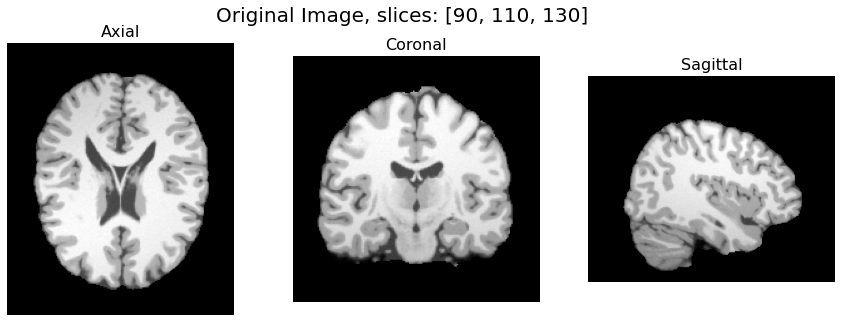

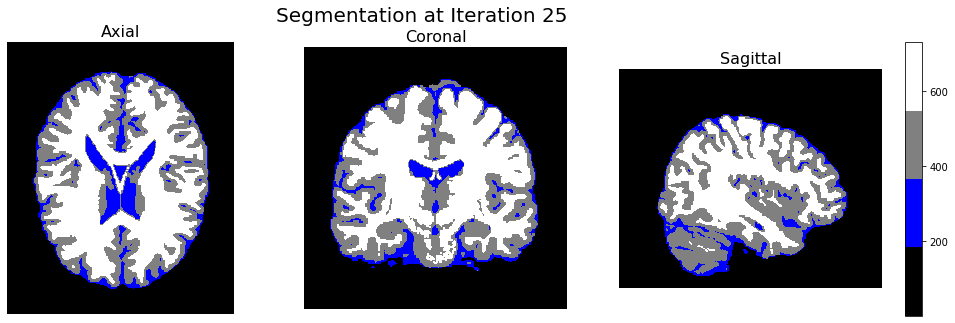

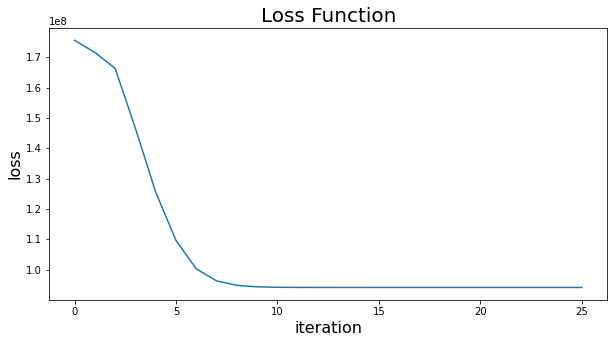

Algorithm converges since cost per iteration is smaller than minDifference.


In [111]:
max_iters=80; abs_tol=1e-16; rel_tol=1e-16; verbose=True; showEveryX = 5
lossHistory = []

for it in range(max_iters):
    cluster_idx = KMeans_model._update_assignment(brainImage, centers, K)
    centers = KMeans_model._update_centers(brainImage, cluster_idx, K)
    loss = KMeans_model._get_loss(brainImage, centers, cluster_idx, K)
    lossHistory.append(loss)

    if it % (showEveryX ) == 0:
        plotOriginalImage(brainImage, slices, title='Original Image')
        segImage = np.copy(brainImage)
        # assign each pixel to cluster mean
        for i in range(K):
            indices_current_cluster = np.where(cluster_idx == i)
            segImage[indices_current_cluster] = centers[i]
        plotSegmentation(segImage, slices, it)
        plotLoss(lossHistory)

    if it:
        diff = np.abs(prev_loss - loss)
        if diff < abs_tol and diff / prev_loss < rel_tol:
            print("Algorithm converges since cost per iteration is smaller than minDifference.")
            break
    prev_loss = loss
    if verbose:
        print('Iteration {:.0f}, Loss: {:.4f}, Centers: {}'.format(it, loss, centers))

The algorithm converged. Let's show our final result!

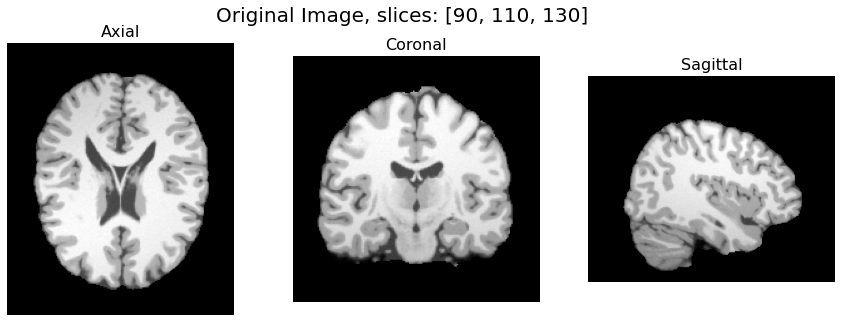

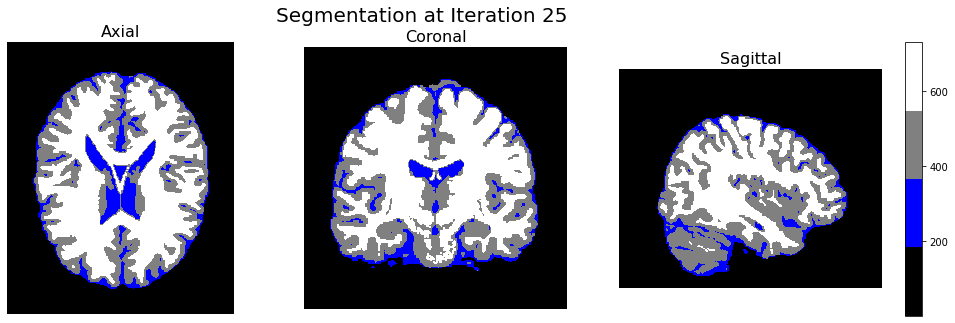

In [112]:
segImage = np.copy(brainImage)

# assign each pixel to cluster mean
for i in range(K):
    indices_current_cluster = np.where(cluster_idx == i)
    segImage[indices_current_cluster] = centers[i]

plotOriginalImage(brainImage, slices, title='Original Image')
plotSegmentation(segImage, slices, it)